### Tutorial: Fine-tuning ABMIL FEATHER-24K on PANDA Dataset

This tutorial fine-tunes a **pretrained ABMIL model (FEATHER-24K)** on the PANDA dataset using pre-extracted UNI v2 features.

**FEATHER-24K Key Features**:
- **Pretrained on PC-108**: 108-way pan-cancer classification on 24K slides from MGB
- **Lightweight**: Only 1.18M parameters (orders of magnitude smaller than slide foundation models)
- **Transfer learning ready**: Can be fine-tuned on consumer-grade GPUs
- **Competitive performance**: Achieves 93.5% on PANDA in benchmarks

**ABMIL Architecture**:
- **Attention-based MIL**: Learns attention weights for each patch
- **Gated attention**: Uses gating mechanism for better feature selection
- **Single-stage training**: Only bag-level supervision (simpler than CLAM)

#### A- Dataset Information & Preprocessing

- **Dataset**: PANDA (Prostate cANcer graDe Assessment)
- **Features**: Pre-extracted UNI v2 features (1536 dimensions)
- **Patch size**: 256x256 pixels at 20x magnification
- **Task**: Multi-class classification (ISUP grades 0-5)
- **Data**:
  - WSI directory: `/media/nadim/Data/prostate-cancer-grade-assessment/train_images`
  - Features directory: `/media/nadim/Data/prostate-cancer-grade-assessment/panda/`
  - Labels CSV: `/media/nadim/Data/prostate-cancer-grade-assessment/train.csv`

**Preprocessing Steps**:
1. Read slide IDs and labels from CSV
2. Scan features directory for available .h5 files
3. Match CSV labels with available features
4. Perform stratified train/val/test split (70/20/10) using sklearn

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from glob import glob

# Configuration
csv_path = '/media/nadim/Data/prostate-cancer-grade-assessment/train.csv'
feats_path = '/media/nadim/Data/prostate-cancer-grade-assessment/panda/'
SEED = 10

# ============================================================================
# GRADE GROUPING FLAGS
# ============================================================================
# Set grade_group=True to group ISUP grades into clinical categories:
#   Group 0: ISUP 0 (no cancer)
#   Group 1: ISUP 1 (low grade)
#   Group 2: ISUP 2-3 (mid grade)
#   Group 3: ISUP 4-5 (high grade)
# Set grade_group=False for original 6-class ISUP grading (0-5)
grade_group = True

# Set exclude_mid_grade=True to exclude ISUP 2-3 from analysis (requires grade_group=True)
# Results in 3-class problem: Group 0 (no cancer), Group 1 (low), Group 2 (high)
exclude_mid_grade = True
# ============================================================================

# Set random seed for reproducibility
np.random.seed(SEED)

print(f"{'='*70}")
print("IMPROVED DATA PREPROCESSING")
if grade_group:
    if exclude_mid_grade:
        print("MODE: Clinical Grade Grouping (3 classes, mid grade excluded)")
    else:
        print("MODE: Clinical Grade Grouping (4 classes)")
else:
    print("MODE: Original ISUP Grading (6 classes)")
print(f"{'='*70}\n")

# Step 1: Read labels and slide IDs from CSV
print("Step 1: Reading labels from CSV...")
df_labels = pd.read_csv(csv_path)

# Select only necessary columns (slide_id and label)
df_labels = df_labels[['slide_id', 'label']]

# Store original ISUP grades
df_labels['isup_grade'] = df_labels['label']

# Apply grade grouping if enabled
if grade_group:
    # Exclude mid grade if requested
    if exclude_mid_grade:
        print(f"  Excluding mid grade (ISUP 2-3) from analysis...")
        df_labels = df_labels[~df_labels['isup_grade'].isin([2, 3])].reset_index(drop=True)
        print(f"  Remaining slides after exclusion: {len(df_labels)}")
    
    def map_isup_to_group(isup_grade):
        """Map ISUP grades to clinical groups"""
        if isup_grade == 0:
            return 0  # No cancer
        elif isup_grade == 1:
            return 1  # Low grade
        elif isup_grade in [2, 3]:
            return 2  # Mid grade
        elif isup_grade in [4, 5]:
            # If mid grade excluded, high grade becomes Group 2
            return 2 if exclude_mid_grade else 3  # High grade
        else:
            raise ValueError(f"Invalid ISUP grade: {isup_grade}")
    
    df_labels['label'] = df_labels['isup_grade'].apply(map_isup_to_group)
    print(f"  Applied grade grouping: ISUP -> Clinical Groups")
    
print(f"  Found {len(df_labels)} slides in CSV with labels")
print(f"  Label distribution in CSV:")
if grade_group:
    if exclude_mid_grade:
        group_names = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 'Group 2 (High grade)']
    else:
        group_names = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 
                       'Group 2 (Mid grade)', 'Group 3 (High grade)']
    for grade in sorted(df_labels['label'].unique()):
        count = len(df_labels[df_labels['label'] == grade])
        print(f"    {group_names[grade]}: {count}")
else:
    for grade in sorted(df_labels['label'].unique()):
        count = len(df_labels[df_labels['label'] == grade])
        print(f"    ISUP {grade}: {count}")

# Step 2: Find all available feature files
print(f"\nStep 2: Scanning features directory...")
feature_files = glob(os.path.join(feats_path, '*.h5'))
available_slide_ids = [os.path.basename(f).replace('.h5', '') for f in feature_files]
print(f"  Found {len(available_slide_ids)} feature files")

# Step 3: Match CSV with available features
print(f"\nStep 3: Matching CSV labels with available features...")
df_labels['has_features'] = df_labels['slide_id'].isin(available_slide_ids)
df_matched = df_labels[df_labels['has_features']].drop(columns=['has_features']).reset_index(drop=True)
missing_count = len(df_labels) - len(df_matched)
print(f"  Matched: {len(df_matched)} slides")
print(f"  Missing features: {missing_count} slides")
print(f"\n  Label distribution after matching:")
if grade_group:
    for grade in sorted(df_matched['label'].unique()):
        count = len(df_matched[df_matched['label'] == grade])
        print(f"    {group_names[grade]}: {count}")
else:
    for grade in sorted(df_matched['label'].unique()):
        count = len(df_matched[df_matched['label'] == grade])
        print(f"    ISUP {grade}: {count}")

# Step 4: Perform stratified train/val/test split using sklearn
print(f"\nStep 4: Performing stratified split (70% train, 20% val, 10% test)...")

# First split: separate test set (10%)
train_val_df, test_df = train_test_split(
    df_matched, 
    test_size=0.10, 
    stratify=df_matched['label'],
    random_state=SEED
)

# Second split: separate train and val from remaining 90% (77.78% train, 22.22% val of remaining)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.222,  # 0.222 * 0.9 ≈ 0.20 of total
    stratify=train_val_df['label'],
    random_state=SEED
)

# Add split column
train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

# Combine back into single dataframe
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print(f"\n{'='*70}")
print("SPLIT SUMMARY")
print(f"{'='*70}")
print(f"Total slides: {len(df)}\n")

print("Split distribution:")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nLabel distribution per split:")
for split_name in ['train', 'val', 'test']:
    split_df = df[df['split'] == split_name]
    print(f"\n{split_name.upper()}:")
    for grade in sorted(df['label'].unique()):
        count = len(split_df[split_df['label'] == grade])
        pct = count / len(split_df) * 100
        if grade_group:
            print(f"  {group_names[grade]}: {count:4d} ({pct:5.1f}%)")
        else:
            print(f"  ISUP {grade}: {count:4d} ({pct:5.1f}%)")

print(f"\n{'='*70}\n")

# Store number of classes for model creation
num_classes = len(df['label'].unique())
print(f"Number of classes: {num_classes}")
if grade_group:
    print(f"Class mapping: {group_names}")
else:
    print(f"Classes: ISUP grades 0-5")

# Display first few rows
df.head(10)

IMPROVED DATA PREPROCESSING
MODE: Clinical Grade Grouping (3 classes, mid grade excluded)

Step 1: Reading labels from CSV...
  Excluding mid grade (ISUP 2-3) from analysis...
  Remaining slides after exclusion: 8031
  Applied grade grouping: ISUP -> Clinical Groups
  Found 8031 slides in CSV with labels
  Label distribution in CSV:
    Group 0 (No cancer): 2892
    Group 1 (Low grade): 2666
    Group 2 (High grade): 2473

Step 2: Scanning features directory...
  Found 10615 feature files

Step 3: Matching CSV labels with available features...
  Matched: 8030 slides
  Missing features: 1 slides

  Label distribution after matching:
    Group 0 (No cancer): 2891
    Group 1 (Low grade): 2666
    Group 2 (High grade): 2473

Step 4: Performing stratified split (70% train, 20% val, 10% test)...

SPLIT SUMMARY
Total slides: 8030

Split distribution:
  Train: 5622 (70.0%)
  Val:   1605 (20.0%)
  Test:  803 (10.0%)

Label distribution per split:

TRAIN:
  Group 0 (No cancer): 2024 ( 36.0%)
  

,slide_id,label,isup_grade,split
0,d14d2e2f09b3499b43ef1049691cfa73,0,0,train
1,c785544bb2e401f81d5b10b377ce829b,1,1,train
2,4aa3b5e41208988c1e018f2713b9e321,2,5,train
3,ecbafab43eea3abffc6cd89c02592e35,1,1,train
4,e34cba2807a8776c31fa61f63ac567cf,2,4,train
5,2b744f7f47a4fbd91e26eba3f37df819,0,0,train
6,da998451f0bdaf4e16b7b41c0881fcba,2,5,train
7,f91d27d0216aa979a0c89f465a03d990,1,1,train
8,c64c12966d164cd0bcc6bfef4ca95500,2,4,train
9,e0818000c58746e9ac0994202db988d0,0,0,train


#### B- Loading Pretrained ABMIL FEATHER-24K Model

**Important ABMIL Notes**:
1. **Batch Size > 1**: ABMIL can process multiple slides per batch (unlike CLAM)
2. **Pretrained weights**: Model is initialized with weights from PC-108 pretraining
3. **Feature freezing options**: Can freeze encoder and only train classifier head
4. **Simpler training**: Only bag-level loss (no instance-level loss like CLAM)

In [ ]:
import osimport torchimport torch.nn as nnimport torch.optim as optimimport h5pyfrom torch.utils.data import Dataset, DataLoaderfrom sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matriximport matplotlib.pyplot as pltimport seaborn as snsfrom tqdm import tqdm# Import MIL-Lab model builderfrom src.builder import create_model# Set deterministic behaviorSEED = 42np.random.seed(SEED)torch.manual_seed(SEED)torch.cuda.manual_seed_all(SEED)torch.backends.cudnn.deterministic = Truetorch.backends.cudnn.benchmark = False# Custom dataset for PANDA with UNI v2 featuresclass PANDAH5Dataset(Dataset):    def __init__(self, feats_path, df, split, num_features=512):        self.df = df[df["split"] == split].reset_index(drop=True)        self.feats_path = feats_path        self.num_features = num_features        self.split = split        def __len__(self):        return len(self.df)    def __getitem__(self, idx):        row = self.df.iloc[idx]        feat_path = os.path.join(self.feats_path, row['slide_id'] + '.h5')                with h5py.File(feat_path, "r") as f:            # Load features and handle both 2D (new Trident) and 3D (old) formats            raw_features = torch.from_numpy(f["features"][:])                        # Trident generates 2D: (num_patches, 1536)            # Old format was 3D: (1, num_patches, 1536)            if len(raw_features.shape) == 3:                # Old format - squeeze first dimension                features = raw_features.squeeze(0).clone()            else:                # New Trident format - already 2D                features = raw_features.clone()        # Sample patches for training to control memory        if self.split == 'train':            num_available = features.shape[0]            if num_available >= self.num_features:                indices = torch.randperm(num_available, generator=torch.Generator().manual_seed(SEED))[:self.num_features]            else:                indices = torch.randint(num_available, (self.num_features,), generator=torch.Generator().manual_seed(SEED))            features = features[indices]        label = torch.tensor(row["label"], dtype=torch.long)        return features, label# Initialize devicedevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")print(f"{'='*70}")print("LOADING PRETRAINED ABMIL FEATHER-24K MODEL")print(f"{'='*70}\n")# Create ABMIL model with pretrained weights# Model naming: 'abmil.base.uni_v2.pc108-24k' means:#   - abmil: model architecture#   - base: configuration (uses default hyperparameters)#   - uni_v2: encoder type (automatically sets in_dim=1536)#   - pc108-24k: pretrained on PC-108 task with 24K slidesprint("Creating model with pretrained weights...")model = create_model(    'abmil.base.uni_v2.pc108-24k',  # Pretrained FEATHER-24K model    num_classes=num_classes,         # Use num_classes from preprocessing    dropout=0.2,                     # Dropout for regularization    gate=True                        # Use gated attention).to(device)print(f"\nDevice: {device}")print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")print(f"Number of classes: {num_classes}")# Create dataloadersbatch_size = 32  # ABMIL can use batch_size > 1train_dataset = PANDAH5Dataset(feats_path, df, "train", num_features=512)val_dataset = PANDAH5Dataset(feats_path, df, "val", num_features=512)test_dataset = PANDAH5Dataset(feats_path, df, "test", num_features=512)train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)print(f"\nDataset sizes:")print(f"  Train batches: {len(train_loader)}")print(f"  Val samples: {len(val_loader)}")print(f"  Test samples: {len(test_loader)}")print(f"\n{'='*70}\n")

#### C- Training Loop (Fine-tuning)

**Fine-tuning Strategy**:
- **Full fine-tuning**: Train all layers (encoder + classifier)
- **Learning rate**: Use smaller LR (1e-4) for pretrained weights
- **Early stopping**: Based on validation loss
- **LR scheduling**: Reduce LR on plateau

**ABMIL Training Notes**:
- Returns single loss (bag-level only)
- Can optionally pass `loss_fn` and `label` to model for convenience
- Simpler than CLAM (no instance-level loss)

In [3]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Training loop
num_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
val_accuracies = []

print(f"\n{'='*70}")
print("Starting ABMIL fine-tuning...")
print(f"{'='*70}\n")

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0.
    
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for features, labels in train_bar:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # ABMIL forward: can provide loss_fn and label for convenience
        results_dict, log_dict = model(features, loss_fn=criterion, label=labels)
        loss = results_dict['loss']
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        train_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
            features, labels = features.to(device), labels.to(device)
            
            # Forward pass with ABMIL
            results_dict, log_dict = model(features, loss_fn=criterion, label=labels)
            logits = results_dict['logits']
            loss = results_dict['loss']
            
            val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_acc)
    
    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Train Loss:     {avg_train_loss:.4f}")
    print(f"  Val Loss:       {avg_val_loss:.4f}")
    print(f"  Val Acc:        {val_acc:.4f}")
    print(f"  LR:             {new_lr:.6f}")
    
    if new_lr < old_lr:
        print(f"  >>> Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_abmil_feather_panda.pth')
        print(f"  >>> Saved best model (Val Loss: {best_val_loss:.4f})")
    
    print(f"{'-'*70}")

print(f"\n{'='*70}")
print("Training complete!")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"{'='*70}\n")


Starting ABMIL fine-tuning...



Epoch 1/10 [Val]: 100%|██████████| 1605/1605 [01:16<00:00, 21.02it/s]



Epoch 1/10 Summary:
  Train Loss:     0.4894
  Val Loss:       0.2871
  Val Acc:        0.9034
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2871)
----------------------------------------------------------------------


Epoch 2/10 [Val]: 100%|██████████| 1605/1605 [01:08<00:00, 23.56it/s]



Epoch 2/10 Summary:
  Train Loss:     0.2595
  Val Loss:       0.2539
  Val Acc:        0.9202
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2539)
----------------------------------------------------------------------


Epoch 3/10 [Val]: 100%|██████████| 1605/1605 [01:10<00:00, 22.75it/s]



Epoch 3/10 Summary:
  Train Loss:     0.2233
  Val Loss:       0.2389
  Val Acc:        0.9221
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2389)
----------------------------------------------------------------------


Epoch 4/10 [Val]: 100%|██████████| 1605/1605 [01:09<00:00, 23.25it/s]



Epoch 4/10 Summary:
  Train Loss:     0.1984
  Val Loss:       0.2317
  Val Acc:        0.9215
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2317)
----------------------------------------------------------------------


Epoch 5/10 [Val]: 100%|██████████| 1605/1605 [01:09<00:00, 23.05it/s]



Epoch 5/10 Summary:
  Train Loss:     0.1798
  Val Loss:       0.2179
  Val Acc:        0.9290
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2179)
----------------------------------------------------------------------


Epoch 6/10 [Val]: 100%|██████████| 1605/1605 [01:08<00:00, 23.33it/s]



Epoch 6/10 Summary:
  Train Loss:     0.1645
  Val Loss:       0.2286
  Val Acc:        0.9252
  LR:             0.000100
----------------------------------------------------------------------


Epoch 7/10 [Val]: 100%|██████████| 1605/1605 [01:08<00:00, 23.44it/s]



Epoch 7/10 Summary:
  Train Loss:     0.1539
  Val Loss:       0.2168
  Val Acc:        0.9283
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2168)
----------------------------------------------------------------------


Epoch 8/10 [Val]: 100%|██████████| 1605/1605 [01:10<00:00, 22.92it/s]



Epoch 8/10 Summary:
  Train Loss:     0.1385
  Val Loss:       0.2209
  Val Acc:        0.9283
  LR:             0.000100
----------------------------------------------------------------------


Epoch 9/10 [Val]: 100%|██████████| 1605/1605 [01:09<00:00, 23.02it/s]



Epoch 9/10 Summary:
  Train Loss:     0.1250
  Val Loss:       0.2141
  Val Acc:        0.9315
  LR:             0.000100
  >>> Saved best model (Val Loss: 0.2141)
----------------------------------------------------------------------


Epoch 10/10 [Val]: 100%|██████████| 1605/1605 [01:09<00:00, 23.20it/s]


Epoch 10/10 Summary:
  Train Loss:     0.1097
  Val Loss:       0.2161
  Val Acc:        0.9302
  LR:             0.000100
----------------------------------------------------------------------

Training complete!
Best validation loss: 0.2141



#### D- Training Curves

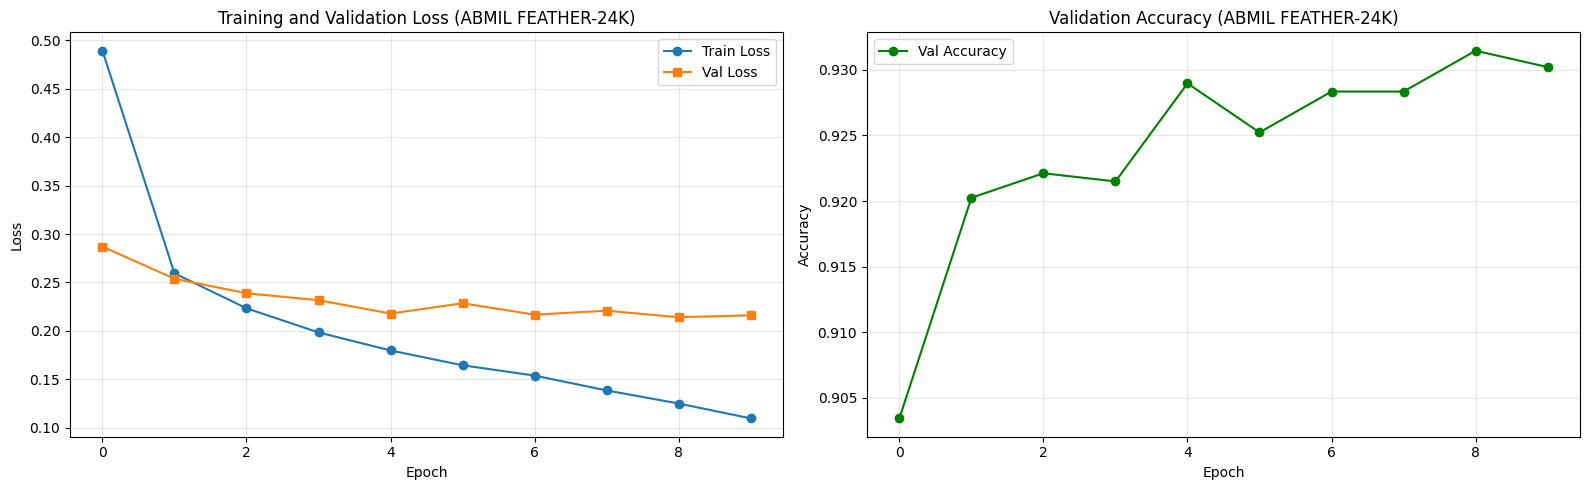

In [4]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss (ABMIL FEATHER-24K)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curve
axes[1].plot(val_accuracies, label='Val Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy (ABMIL FEATHER-24K)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves_abmil_feather_panda.png', dpi=300, bbox_inches='tight')
plt.show()

#### E- Test Evaluation

Testing: 100%|██████████| 803/803 [00:37<00:00, 21.18it/s]



ABMIL FEATHER-24K Test Results
Test Accuracy:                    0.9265
Test Balanced Accuracy:           0.9264
Test Quadratic Weighted Kappa:    0.9197



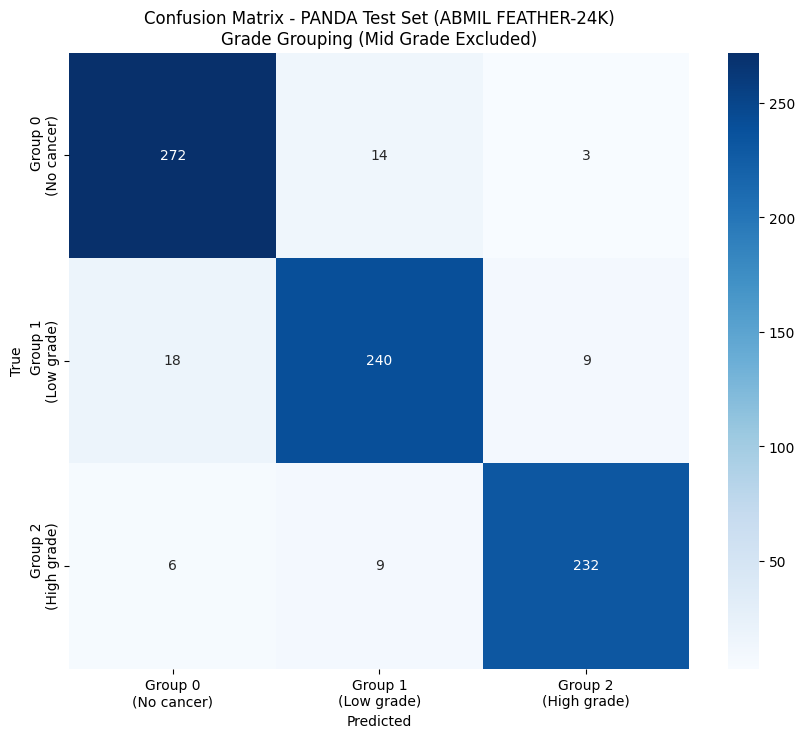


Per-class accuracy:
  Group 0 (No cancer): 0.9412 (272/289)
  Group 1 (Low grade): 0.8989 (240/267)
  Group 2 (High grade): 0.9393 (232/247)


In [5]:
# Load best model
model.load_state_dict(torch.load('best_model_abmil_feather_panda.pth'))
model.eval()

# Test evaluation
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for features, labels in tqdm(test_loader, desc='Testing'):
        features, labels = features.to(device), labels.to(device)
        
        # ABMIL forward pass (no need for loss_fn during inference)
        results_dict, log_dict = model(features)
        logits = results_dict['logits']
        
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
test_balanced_acc = balanced_accuracy_score(all_labels, all_preds)
test_kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

print(f"\n{'='*70}")
print("ABMIL FEATHER-24K Test Results")
print(f"{'='*70}")
print(f"Test Accuracy:                    {test_acc:.4f}")
print(f"Test Balanced Accuracy:           {test_balanced_acc:.4f}")
print(f"Test Quadratic Weighted Kappa:    {test_kappa:.4f}")
print(f"{'='*70}\n")

# Generate class labels for confusion matrix
if grade_group:
    if exclude_mid_grade:
        class_labels = ['Group 0\n(No cancer)', 'Group 1\n(Low grade)', 'Group 2\n(High grade)']
    else:
        class_labels = ['Group 0\n(No cancer)', 'Group 1\n(Low grade)', 
                        'Group 2\n(Mid grade)', 'Group 3\n(High grade)']
else:
    class_labels = [f'ISUP {i}' for i in range(num_classes)]

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
if grade_group:
    if exclude_mid_grade:
        title_text = 'Confusion Matrix - PANDA Test Set (ABMIL FEATHER-24K)\nGrade Grouping (Mid Grade Excluded)'
    else:
        title_text = 'Confusion Matrix - PANDA Test Set (ABMIL FEATHER-24K) - Grade Grouping'
else:
    title_text = 'Confusion Matrix - PANDA Test Set (ABMIL FEATHER-24K)'
plt.title(title_text)
plt.savefig('confusion_matrix_abmil_feather_panda.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\nPer-class accuracy:")
for i in range(num_classes):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    if grade_group:
        print(f"  {class_labels[i].replace(chr(10), ' ')}: {class_acc:.4f} ({cm[i, i]}/{int(cm[i].sum())})")
    else:
        print(f"  ISUP {i}: {class_acc:.4f} ({cm[i, i]}/{int(cm[i].sum())})")

#### F- Visualization Helper Functions

Reusable functions to eliminate code duplication

In [6]:
import h5py
import torch
import openslide
from PIL import Image
import numpy as np
from src.visualization import TridentVisualizer

def load_slide_data(slide_id, feats_path, default_patch_size=256):
    """Load features, coordinates, and patch size for a given slide"""
    feat_path = os.path.join(feats_path, slide_id + '.h5')
    
    with h5py.File(feat_path, 'r') as f:
        patch_features = torch.from_numpy(f['features'][:]).squeeze(0)
        coords = f['coords_patching'][:]
        
        if hasattr(f['coords_patching'], 'attrs') and 'patch_size' in f['coords_patching'].attrs:
            patch_size_level0 = int(f['coords_patching'].attrs['patch_size'])
        else:
            patch_size_level0 = default_patch_size
    
    # Ensure coords and features have the same length
    min_len = min(len(coords), len(patch_features))
    coords = coords[:min_len]
    patch_features = patch_features[:min_len]
    
    return patch_features, coords, patch_size_level0

def get_abmil_predictions(model, patch_features, device):
    """Get ABMIL model predictions and attention scores"""
    model.eval()
    with torch.no_grad():
        features_input = patch_features.float().to(device).unsqueeze(0)
        
        # ABMIL forward pass with attention
        results_dict, log_dict = model(
            features_input,
            return_attention=True
        )
        
        logits = results_dict['logits']
        attention_scores = log_dict['attention'].cpu().numpy().squeeze()
        predicted_class = torch.argmax(logits, dim=1).item()
        
    return predicted_class, attention_scores, logits

def extract_top_patches(slide_path, coords, attention_scores, patch_size_level0, top_k=3):
    """Extract top K patches based on attention scores"""
    # Get indices of top k patches
    top_indices = np.argsort(attention_scores)[-top_k:][::-1]
    
    # Open slide
    try:
        wsi = openslide.OpenSlide(slide_path)
    except:
        return None, None, None
    
    patches = []
    scores = []
    locations = []
    
    for idx in top_indices:
        x, y = coords[idx]
        score = attention_scores[idx]
        
        # Extract patch at level 0
        patch = wsi.read_region((int(x), int(y)), 0, (patch_size_level0, patch_size_level0))
        patch = patch.convert('RGB')
        
        patches.append(patch)
        scores.append(score)
        locations.append((x, y))
    
    wsi.close()
    return patches, scores, locations

print("Helper functions defined successfully!")

Helper functions defined successfully!


#### G- Top 3 Patches Per Category

Visualize the top 3 patches with highest attention scores for each ISUP grade

Extracting Top 3 Patches Per Clinical Grade Group (Mid Grade Excluded)

Processing Group 0 (No cancer): 0d11cd4b1285e9704ecd9fbee3ee8544
  Top 3 attention scores: [np.float32(6.069318), np.float32(4.1796117), np.float32(4.111824)]
  Predicted: Group 0 (No cancer)

Processing Group 1 (Low grade): 51d0d7b3a0f1769117ed6e3d64445f33
  Top 3 attention scores: [np.float32(10.055088), np.float32(10.027621), np.float32(10.012407)]
  Predicted: Group 1 (Low grade)

Processing Group 2 (High grade): d2e8ff5257ef522c1d7bef30c96d06df
  Top 3 attention scores: [np.float32(10.658859), np.float32(10.648011), np.float32(10.446)]
  Predicted: Group 2 (High grade)



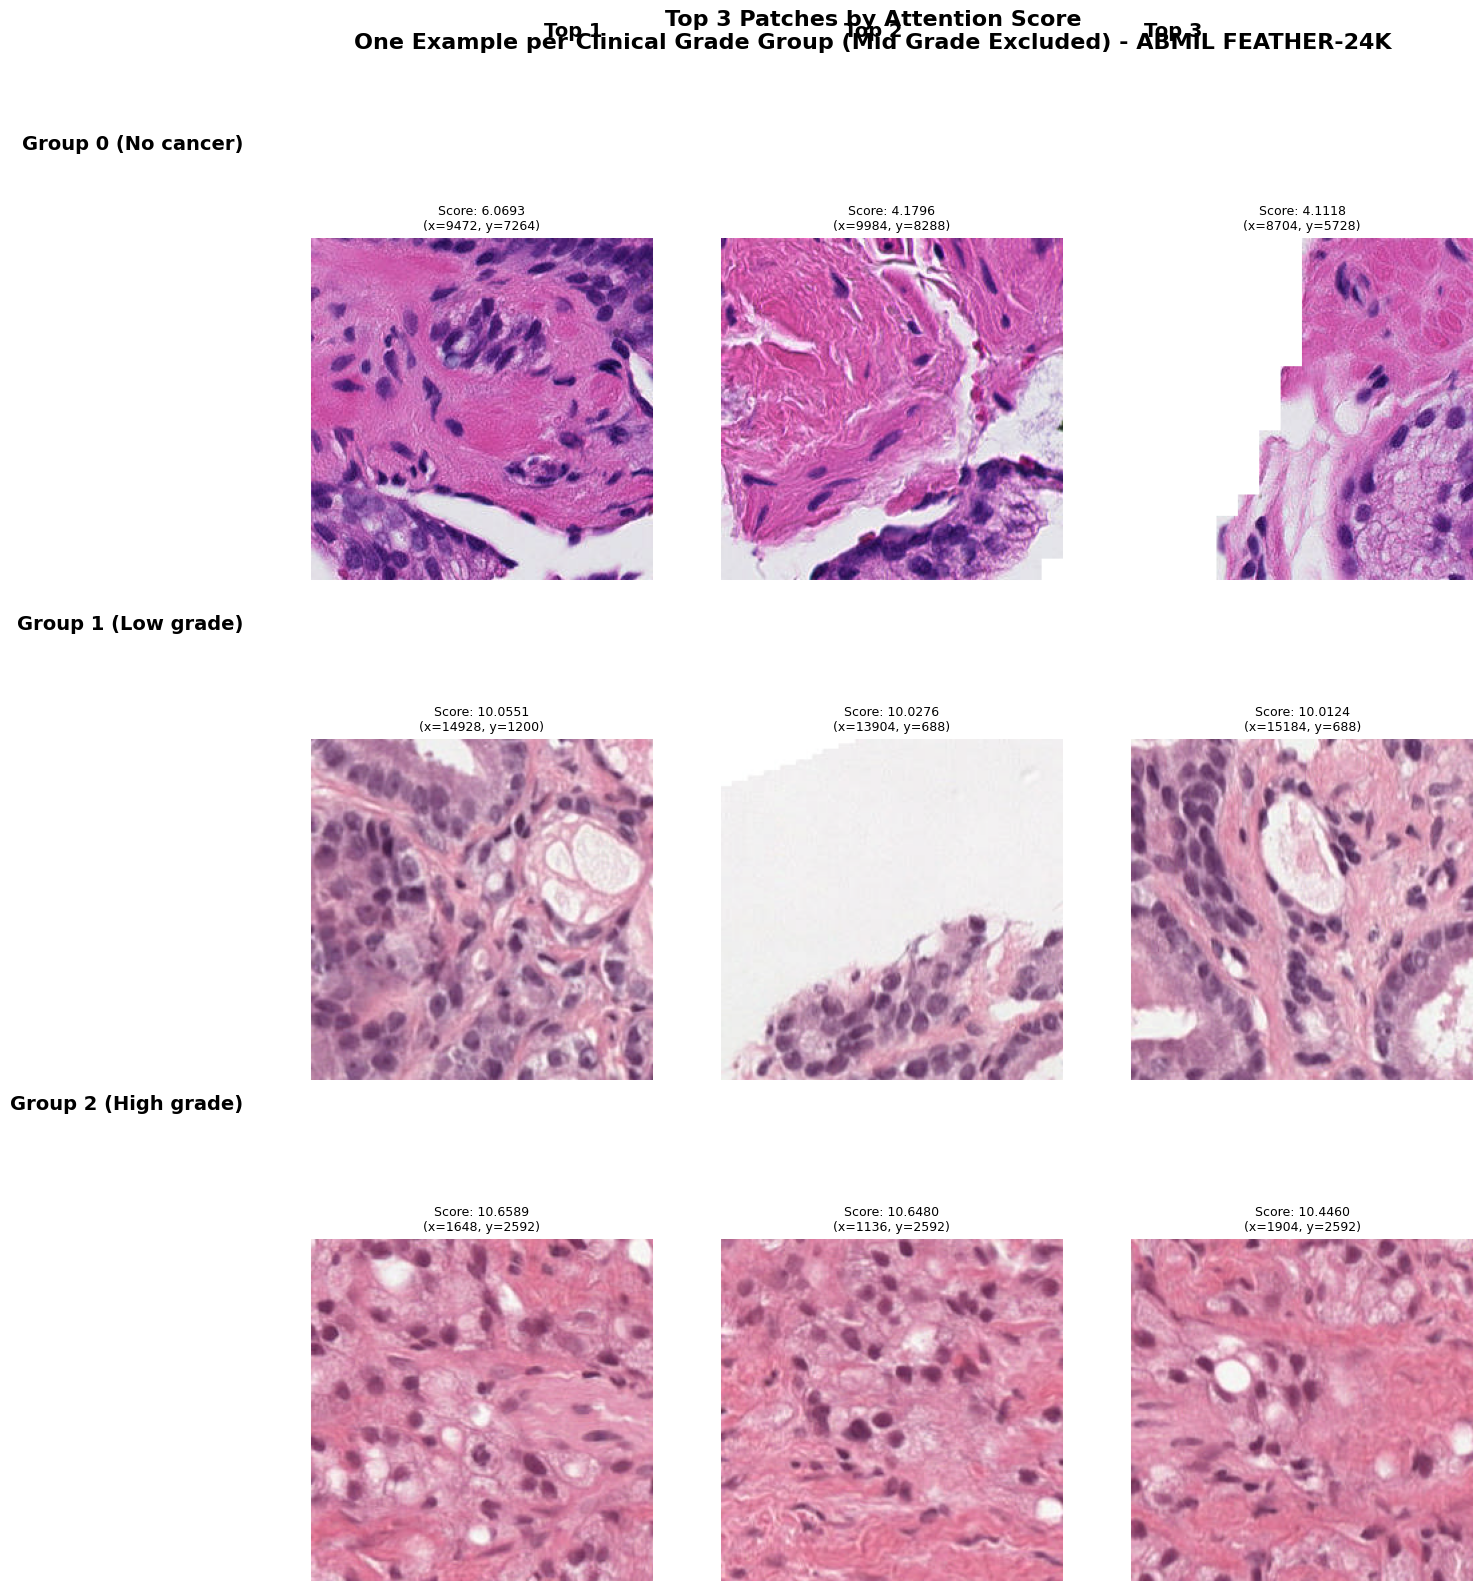


Top Patches Visualization Complete!
Saved to: ./heatmap_output_abmil_feather/top_3_patches_per_grade.png
Individual patches saved to: ./heatmap_output_abmil_feather/top_patches_per_grade/


In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Get one example from each class
test_df = df[df['split'] == 'test']
example_slides = []
for grade in range(num_classes):
    grade_slides = test_df[test_df['label'] == grade]
    if len(grade_slides) > 0:
        example_slides.append(grade_slides.iloc[0])

print(f"{'='*70}")
if grade_group:
    if exclude_mid_grade:
        print("Extracting Top 3 Patches Per Clinical Grade Group (Mid Grade Excluded)")
    else:
        print("Extracting Top 3 Patches Per Clinical Grade Group")
else:
    print("Extracting Top 3 Patches Per ISUP Grade")
print(f"{'='*70}\n")

# Create output directory for top patches
top_patches_dir = './heatmap_output_abmil_feather/top_patches_per_grade'
os.makedirs(top_patches_dir, exist_ok=True)

# Generate class labels
if grade_group:
    if exclude_mid_grade:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 'Group 2 (High grade)']
    else:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 
                        'Group 2 (Mid grade)', 'Group 3 (High grade)']
else:
    class_labels = [f'ISUP {i}' for i in range(num_classes)]

# Create figure with subplots: num_classes rows x 3 columns (top 3 patches)
fig = plt.figure(figsize=(15, 6*num_classes))
gs = GridSpec(num_classes, 3, figure=fig, hspace=0.3, wspace=0.2)

for grade_idx, slide_row in enumerate(example_slides):
    slide_id = slide_row['slide_id']
    true_label = slide_row['label']
    
    print(f"Processing {class_labels[true_label]}: {slide_id}")
    
    # Load slide data using helper function
    patch_features, coords, patch_size_level0 = load_slide_data(
        slide_id, feats_path, default_patch_size=256
    )
    
    # Get ABMIL predictions and attention scores
    predicted_class, attention_scores, logits = get_abmil_predictions(
        model, patch_features, device
    )
    
    # Extract top 3 patches
    slide_path = f'/media/nadim/Data/prostate-cancer-grade-assessment/train_images/{slide_id}.tiff'
    patches, scores, locations = extract_top_patches(
        slide_path, coords, attention_scores, patch_size_level0, top_k=3
    )
    
    if patches is None:
        print(f"  Could not load slide {slide_id}, skipping...")
        continue
    
    # Display top 3 patches for this grade
    for patch_idx, (patch, score, (x, y)) in enumerate(zip(patches, scores, locations)):
        ax = fig.add_subplot(gs[grade_idx, patch_idx])
        ax.imshow(patch)
        ax.axis('off')
        
        # Title with score and location
        title = f'Score: {score:.4f}\n(x={int(x)}, y={int(y)})'
        ax.set_title(title, fontsize=9)
        
        # Save individual patch
        if grade_group:
            patch_filename = f'Group{true_label}_{slide_id[:8]}_top{patch_idx+1}_score{score:.4f}.png'
        else:
            patch_filename = f'ISUP{true_label}_{slide_id[:8]}_top{patch_idx+1}_score{score:.4f}.png'
        patch.save(os.path.join(top_patches_dir, patch_filename))
    
    # Add row label on the left
    spacing = 0.92 - (grade_idx * (0.80 / num_classes))
    fig.text(0.08, spacing, class_labels[true_label], 
             va='center', ha='right', fontsize=14, fontweight='bold')
    
    print(f"  Top 3 attention scores: {scores}")
    print(f"  Predicted: {class_labels[predicted_class]}\n")

# Add column headers
fig.text(0.30, 0.98, 'Top 1', ha='center', fontsize=14, fontweight='bold')
fig.text(0.50, 0.98, 'Top 2', ha='center', fontsize=14, fontweight='bold')
fig.text(0.70, 0.98, 'Top 3', ha='center', fontsize=14, fontweight='bold')

if grade_group:
    if exclude_mid_grade:
        title_text = 'Top 3 Patches by Attention Score\nOne Example per Clinical Grade Group (Mid Grade Excluded) - ABMIL FEATHER-24K'
    else:
        title_text = 'Top 3 Patches by Attention Score - One Example per Clinical Grade Group (ABMIL FEATHER-24K)'
else:
    title_text = 'Top 3 Patches by Attention Score - One Example per ISUP Grade (ABMIL FEATHER-24K)'
plt.suptitle(title_text, fontsize=16, fontweight='bold', y=0.995)

# Save figure
output_path = os.path.join('./heatmap_output_abmil_feather', 'top_3_patches_per_grade.png')
plt.savefig(output_path, dpi=200, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print("Top Patches Visualization Complete!")
print(f"{'='*70}")
print(f"Saved to: {output_path}")
print(f"Individual patches saved to: {top_patches_dir}/")

#### H- Heatmap Visualization

Visualize ABMIL attention heatmaps overlaid on whole slide images

ABMIL FEATHER-24K Attention Heatmap Visualization
Visualizing 3 slides from different classes

Processing slide 1/3: 0d11cd4b1285e9704ecd9fbee3ee8544 (Group 0 (No cancer))

Creating Trident-style heatmap:
  WSI level 0 dimensions: (20480, 25600)
  Visualization level: 2
  Downsample: 16.0
  Region size: (np.int64(1280), np.int64(1600))
  Number of patches: 629
  Score range (after rank normalization): [0.0016, 1.0000]
  Creating overlay...
  Applying colormap...
  Reading background image...
  Blending (alpha=0.4)...
  Saved to: ./heatmap_output_abmil_feather/0d11cd4b1285e9704ecd9fbee3ee8544_Group0_pred0_abmil_feather.png
  Done!
  Attention range: [-4.0254, 6.0693]
  Predicted: Group 0 (No cancer)

Processing slide 2/3: 51d0d7b3a0f1769117ed6e3d64445f33 (Group 1 (Low grade))

Creating Trident-style heatmap:
  WSI level 0 dimensions: (24576, 7168)
  Visualization level: 2
  Downsample: 16.0
  Region size: (np.int64(1536), np.int64(448))
  Number of patches: 500
  Score range (after rank

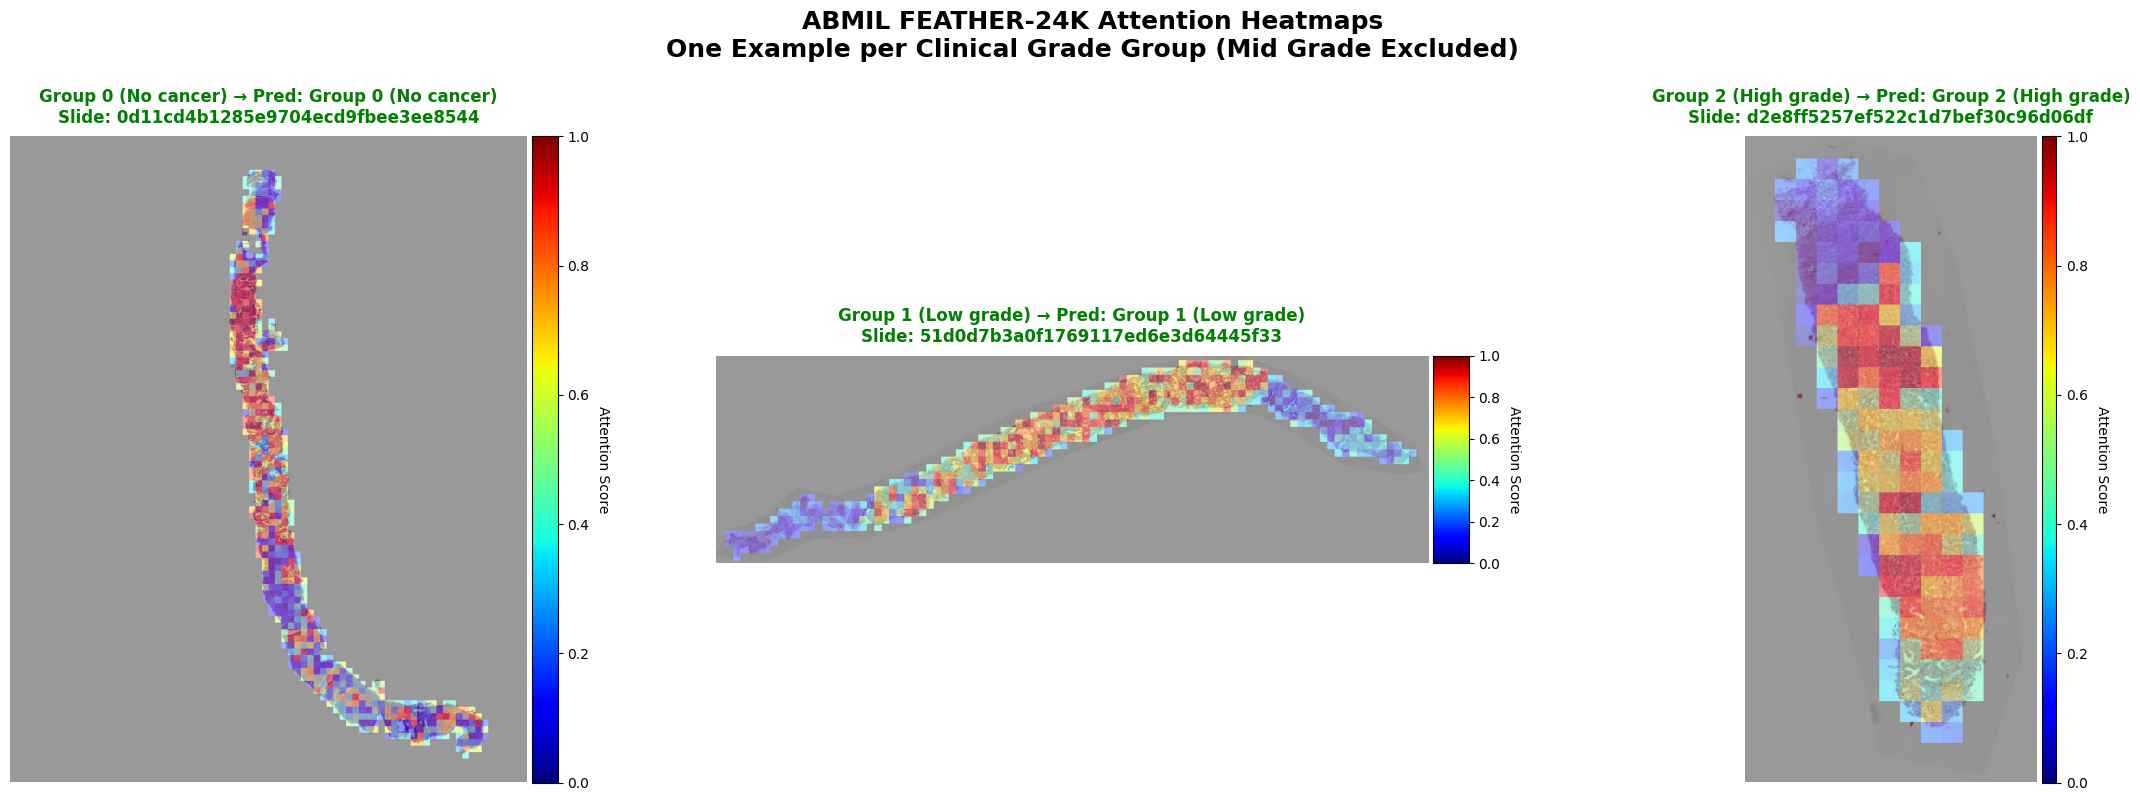


Heatmap Visualization Complete!
Output directory: ./heatmap_output_abmil_feather
- Individual heatmaps saved for each class
- Comparison grid: all_grades_comparison_abmil_feather.png


In [8]:
from src.visualization import TridentVisualizer
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get one example from each class
test_df = df[df['split'] == 'test']
example_slides = []
for grade in range(num_classes):
    grade_slides = test_df[test_df['label'] == grade]
    if len(grade_slides) > 0:
        example_slides.append(grade_slides.iloc[0])
    else:
        print(f"Warning: No test slides found for class {grade}")

# Generate class labels
if grade_group:
    if exclude_mid_grade:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 'Group 2 (High grade)']
    else:
        class_labels = ['Group 0 (No cancer)', 'Group 1 (Low grade)', 
                        'Group 2 (Mid grade)', 'Group 3 (High grade)']
else:
    class_labels = [f'ISUP {i}' for i in range(num_classes)]

print(f"{'='*70}")
print(f"ABMIL FEATHER-24K Attention Heatmap Visualization")
print(f"{'='*70}")
print(f"Visualizing {len(example_slides)} slides from different classes\n")

# Create output directory
output_dir = './heatmap_output_abmil_feather'
os.makedirs(output_dir, exist_ok=True)

# Create figure with appropriate grid size
if num_classes == 3:
    # 1x3 layout for 3 classes
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
elif num_classes == 4:
    # 2x2 layout for 4 classes
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
else:
    # 2x3 layout for 6 classes
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))
axes = axes.flatten()

for idx, slide_row in enumerate(example_slides):
    slide_id = slide_row['slide_id']
    true_label = slide_row['label']
    
    print(f"Processing slide {idx+1}/{len(example_slides)}: {slide_id} ({class_labels[true_label]})")
    
    # Load slide data using helper function
    patch_features, coords, patch_size_level0 = load_slide_data(
        slide_id, feats_path, default_patch_size=256
    )
    
    # Get ABMIL predictions and attention scores using helper function
    predicted_class, attention_scores, logits = get_abmil_predictions(
        model, patch_features, device
    )
    
    # Create heatmap using TridentVisualizer
    slide_path = f'/media/nadim/Data/prostate-cancer-grade-assessment/train_images/{slide_id}.tiff'
    viz = TridentVisualizer(model, wsi_path=slide_path)
    
    if grade_group:
        output_filename = f'{slide_id}_Group{true_label}_pred{predicted_class}_abmil_feather.png'
    else:
        output_filename = f'{slide_id}_ISUP{true_label}_pred{predicted_class}_abmil_feather.png'
    
    heatmap = viz.create_heatmap(
        features=patch_features,
        coords=coords,
        attention_scores=attention_scores,
        patch_size_level0=patch_size_level0,
        vis_level=-1,
        cmap='jet',
        alpha=0.4,
        normalize=True,
        output_path=os.path.join(output_dir, output_filename)
    )
    
    # Display heatmap with colorbar
    im = axes[idx].imshow(heatmap)
    axes[idx].axis('off')
    
    # Add colorbar
    divider = make_axes_locatable(axes[idx])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=0, vmax=1), cmap='jet'), cax=cax)
    cbar.set_label('Attention Score', rotation=270, labelpad=15)
    
    # Title with true and predicted labels (green if correct, red if incorrect)
    title_color = 'green' if predicted_class == true_label else 'red'
    axes[idx].set_title(
        f'{class_labels[true_label]} → Pred: {class_labels[predicted_class]}\nSlide: {slide_id}',
        fontsize=12, fontweight='bold', color=title_color, pad=10
    )
    
    print(f"  Attention range: [{attention_scores.min():.4f}, {attention_scores.max():.4f}]")
    print(f"  Predicted: {class_labels[predicted_class]}\n")

# Hide unused subplots
if num_classes == 3:
    total_subplots = 3
elif num_classes == 4:
    total_subplots = 4
else:
    total_subplots = 6
    
for idx in range(len(example_slides), total_subplots):
    axes[idx].axis('off')

if grade_group:
    if exclude_mid_grade:
        title_text = 'ABMIL FEATHER-24K Attention Heatmaps\nOne Example per Clinical Grade Group (Mid Grade Excluded)'
    else:
        title_text = 'ABMIL FEATHER-24K Attention Heatmaps - One Example per Clinical Grade Group'
else:
    title_text = 'ABMIL FEATHER-24K Attention Heatmaps - One Example per ISUP Grade'
    
plt.suptitle(title_text, fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'all_grades_comparison_abmil_feather.png'), dpi=200, bbox_inches='tight')
plt.show()

print(f"\n{'='*70}")
print("Heatmap Visualization Complete!")
print(f"{'='*70}")
print(f"Output directory: {output_dir}")
print(f"- Individual heatmaps saved for each class")
print(f"- Comparison grid: all_grades_comparison_abmil_feather.png")